# Downloading documents from Wikipedia

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
from utils import BFSScraper, CustomStemmer, BubbleChart, Ranker


In [3]:
bfs_scrap = BFSScraper(n_to_visit=3)
bfs_scrap.bfs('https://en.wikipedia.org/wiki/Jazz', 2)

2 sites already collected: : 2it [00:05,  2.64s/it]


In [ ]:
bfs_scrap.generate_summary()

In [ ]:
bfs_scrap.generate_csv()

In [ ]:
texts = pd.read_csv('text.csv', index_col=0).T
texts.head()

,content,num_of_links,selected_links
https://en.wikipedia.org/wiki/Jazz,\nJazz is a music genre that originated in the...,863,['https://en.wikipedia.org/wiki/Branford_Marsa...
https://en.wikipedia.org/wiki/Branford_Marsalis,"Branford Marsalis (born August 26, 1960) is an...",295,['https://en.wikipedia.org/wiki/Freddie_Hubbar...


In [ ]:
stemmer = CustomStemmer(texts)
preprocessed = stemmer.process_corpus()

In [ ]:
stemmer.generate_csv()

All files available [here](https://drive.google.com/drive/folders/1FkuFF7tCvBj8pTVDtOtFXtfSUOH7a2vw?usp=sharing), as git doesn't support so large files 

## Visualization of data

In [3]:
data = pd.read_csv('processed.csv', index_col=0)
data.head()

,text
https://en.wikipedia.org/wiki/Jazz,Jazz music genre originated communities New Or...
https://en.wikipedia.org/wiki/Branford_Marsalis,Branford Marsalis born August American saxopho...


In [ ]:
words = [text.split() for text in data['text']]
words = [
    word for document in words for word in document]


Top 10 most occured words

In [11]:
from collections import Counter

counter = Counter(words)
cols = [x[0].lower() for x in counter.most_common(10)]
for pair in counter.most_common(10):
    print(f'{pair[0]}: {pair[1]}')

jazz: 346
music: 135
The: 116
In: 86
musicians: 73
New: 62
Marsalis: 61
Jazz: 49
first: 47
band: 41


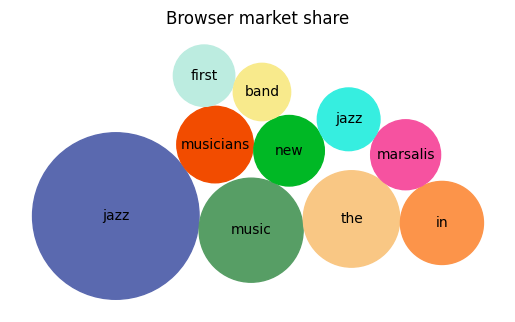

In [12]:
bubble_chart = BubbleChart(area=[x[1] for x in counter.most_common(10)],
                           bubble_spacing=0.1)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
colors = ['#5A69AF', '#579E65', '#F9C784', '#FC944A', '#F24C00', '#00B825',
          '#F652A0', '#36EEE0', '#BCECE0', '#F8EA8C']
bubble_chart.plot(
    ax, cols, colors)
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Browser market share')

plt.show()


Co-occurances

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

CountVec = CountVectorizer()
CountData = CountVec.fit_transform(data['text'])
 
wordsM = (CountData.T)@CountData

In [14]:
df = pd.DataFrame(wordsM.toarray(),
                  columns=CountVec.get_feature_names_out(), index=CountVec.get_feature_names_out())
df

,aaron,abandoned,abandoning,abandonment,abbey,abercrombie,ability,able,abolition,abound,...,york,you,young,younger,your,youtube,zappa,zawinul,zbigniew,zorn
aaron,1,4,3,1,1,1,2,7,1,1,...,16,1,16,6,1,1,2,3,1,1
abandoned,4,16,12,4,4,4,8,28,4,4,...,64,4,64,24,4,4,8,12,4,4
abandoning,3,12,9,3,3,3,6,21,3,3,...,48,3,48,18,3,3,6,9,3,3
abandonment,1,4,3,1,1,1,2,7,1,1,...,16,1,16,6,1,1,2,3,1,1
abbey,1,4,3,1,1,1,2,7,1,1,...,16,1,16,6,1,1,2,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
youtube,1,4,3,1,1,1,2,7,1,1,...,16,1,16,6,1,1,2,3,1,1
zappa,2,8,6,2,2,2,4,14,2,2,...,32,2,32,12,2,2,4,6,2,2
zawinul,3,12,9,3,3,3,6,21,3,3,...,48,3,48,18,3,3,6,9,3,3
zbigniew,1,4,3,1,1,1,2,7,1,1,...,16,1,16,6,1,1,2,3,1,1


Biggest number of co-occurance

In [15]:
a = wordsM.copy()
for i in range(a.shape[0]):
    a[i,i] = -1
x, y = np.unravel_index(a.argmax(), a.shape)
print(f'The most co-occurances are: {CountVec.get_feature_names_out()[x]},\
     {CountVec.get_feature_names_out()[y]} with a value of {a[x,y]}')


The most co-occurances are: music,     jazz with a value of 51325


In [16]:
import networkx as nx
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

import nxviz as nv
from nxviz import annotate


d:\polibuda\sem5\IR\WikipediaRecommender\.venv\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


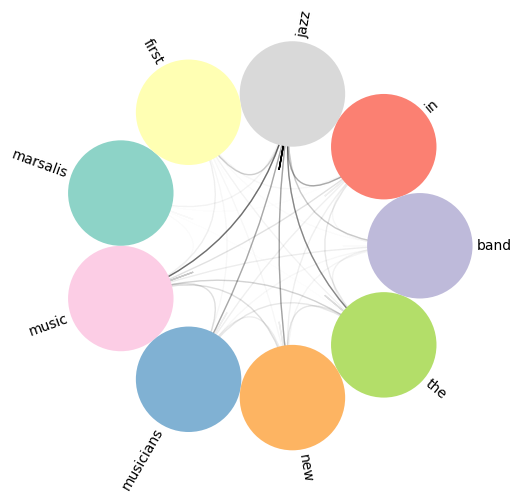

In [34]:
top = df[cols].loc[cols]
G = nx.from_numpy_array(top.values)
mapping = {x: cols[x] for x in range(len(cols))}
G = nx.relabel_nodes(G, mapping)

for v, name in zip(G, cols):
    G.nodes[v]["class"] = G.degree(v, weight="weight")
    G.nodes[v]["name"] = name

ax = nv.circos(
    G,
    node_color_by="class",
    edge_alpha_by="weight",
    group_by="name",
)

ax.figure.tight_layout()
annotate.circos_labels(G, group_by="name", layout="rotate")


## Rank

In [4]:
ranker = Ranker(data)

In [5]:
previous = BFSScraper(n_to_visit=3)
previous.bfs('https://en.wikipedia.org/wiki/Blues', 2)

2 sites already collected: : 2it [00:03,  1.95s/it]


In [6]:
docs = pd.DataFrame(previous.pages).T
ranker.rank(docs)


{'https://en.wikipedia.org/wiki/Blues': 0.34711416872191925,
 'https://en.wikipedia.org/wiki/Newport_Folk_Festival': 0.15612903556237884}